# CNN training

In [1]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Tensorflow version 2.2.0


In [54]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [8]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [9]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)

In [10]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [11]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

In [164]:
def cnn_model(model_name):
    if model_name == "CNN_model":
        model = Sequential()
        # The first two layers with 32 filters of window size 3x3
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nClasses, activation='softmax'))
        
        #opt = keras.optimizers.Adam(learning_rate=0.01)
        #The learning rate. Defaults to 0.001
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    elif model_name == "MobileNet_v1":
        model = tf.keras.applications.MobileNet(
                    input_shape=None,
                    alpha=1.0,
                    depth_multiplier=1,
                    dropout=0.001,
                    include_top=True,
                    weights="imagenet",
                    input_tensor=None,
                    pooling=None,
                    classes=1000,
                    classifier_activation="softmax"
                )
        ## self added FC layer        
        new_model = Sequential()
        new_model.add(model)
        new_model.add(Flatten())
        new_model.add(Dense(512,activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(nClasses, activation='softmax'))

        new_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
        return new_model
    
    elif model_name == 'ResNet50':
        model = tf.keras.applications.ResNet50(
                include_top=True,
                weights="imagenet",
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000
            )
        ## self added FC layer        
        new_model = Sequential()
        new_model.add(model)
        new_model.add(Flatten())
        new_model.add(Dense(512,activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(nClasses, activation='softmax'))

        new_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
        return new_model
    
    else:
        print("[Error] No this model%s:"%model_name)
        pdb.set_trace()

In [40]:
def pred_roc_data(model, img, label_one_hot):
    pred_keras = model.predict(img).ravel() # ravel(): Flatten the array
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_one_hot.ravel(), pred_keras) 
    auc_keras = auc(fpr_keras, tpr_keras)
    return fpr_keras, tpr_keras, auc_keras

# Processing

In [16]:
img_width, img_height = 224, 224

In [ ]:
# ## For rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_del_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_del_image_info.list'

In [ ]:
# ## For rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_dup_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_dup_image_info.list'

In [ ]:
# ## For splited rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

In [ ]:
## For splited rare duplications
true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [ ]:
true_cnv_df  = pd.read_csv(true_file,  header=0,sep='\t')
false_cnv_df = pd.read_csv(false_file, header=0,sep='\t')

In [ ]:
true_images_path_list  = true_cnv_df['image_path']
false_images_path_list = false_cnv_df['image_path']

In [ ]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

### Loading images from list to numpy array

In [ ]:
false_img_np = loadImgs(false_images_path_list, img_width, img_height)
false_img_np.shape

In [ ]:
true_img_np = loadImgs(true_images_path_list, img_width, img_height)
true_img_np.shape

### Generage labels

In [ ]:
true_label = [1 for i in range(0,len(true_img_np))]
false_label = [0 for i in range(0,len(false_img_np))]
print(true_label[0:5], false_label[0:5])
print(len(true_label), len(false_label))

### Combine true & false data

In [ ]:
combined_cnv_info_df = true_cnv_df.append(false_cnv_df, ignore_index=True)
#combined_cnv_info_index = list(range(len(combined_cnv_info_df)))
combined_img_np = np.vstack((true_img_np, false_img_np))
combined_label = true_label + false_label

In [ ]:
combined_cnv_info_df.shape, true_cnv_df.shape, false_cnv_df.shape

### Backup or restore

In [3]:
backup_path = '/home/rt2776/cnv_espresso/images_rare/data_backup/'
# os.makedirs(backup_path, exist_ok=True)

In [ ]:
## Backup

# project_name = 'rare_entire_del'
# combined_cnv_info_df.to_csv(backup_path+'rare_del_entire_cnv_info.csv')
# np.save(backup_path+'rare_del_entire_img', combined_img_np)
# np.save(backup_path+'rare_del_entire_label', combined_label)

# project_name = 'rare_entire_dup'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_dup_info.csv')
# np.save(backup_path+'rare_entire_dup_img', combined_img_np)
# np.save(backup_path+'rare_entire_dup_label', combined_label)

In [207]:
## Restore

# ## Rare entire deletions
# project_name = 'rare_del_entire'

# Rare entire duplications
# project_name = 'rare_entire_dup'

# combined_img_np = np.load(backup_path + project_name + '_img.npy')
# combined_label = np.load(backup_path + project_name + '_label.npy')
# combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_img_np.npy')

# # # rare split deletion
# project_name = 'rare_split_del'
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_splits_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_splits_img_np.npy')

# rare split duplications
project_name = 'rare_split_dup'

combined_img_np = np.load(backup_path + project_name + '_img.npy')
combined_label = np.load(backup_path + project_name + '_label.npy')
#combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

print("Project:%s dataset loaded."%project_name)
print("  -- Shape of image array: ", combined_img_np.shape)
print("  -- Shape of label      : ", combined_label.shape)
#print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)

Project:rare_split_dup dataset loaded.
  -- Shape of image array:  (72896, 224, 224, 3)
  -- Shape of label      :  (72896,)
  -- Shape of CNV info   :  (6169, 22)


### Shuffle

In [ ]:
# combined_cnv_info_df, combined_img_np, combined_label = sklearn.utils.shuffle(combined_cnv_info_df, 
#                                                                                 combined_img_np,
#                                                                                 combined_label,
#                                                                                 random_state=3) #random_state is the seed

In [ ]:
i=random.randrange(len(combined_img_np))
showImg(combined_img_np[i]),combined_label[i],combined_cnv_info_df.iloc[i,:],combined_cnv_info_df.iloc[i,20]

In [ ]:
# tmp = list(zip(combined_img, combined_label, combined_cnv_info_index))
# random.seed(3)
# random.shuffle(tmp)
# combined_img, combined_label, combined_cnv_info_index = zip(*tmp)

## Split dataset into training(80%) and testing(20%) dataset

In [176]:
## split image arrays
train_img, test_img, train_label, test_label, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img_np,
                                                                                                    combined_label,
                                                                                                    combined_cnv_info_df,
                                                                                                    test_size=0.2,
                                                                                                    shuffle=True,
                                                                                                    random_state=3)

train_img, val_img, train_label, val_label, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                  train_label,
                                                                                                  train_cnv_info_df,
                                                                                                  test_size=0.25,
                                                                                                  shuffle=True,
                                                                                                  random_state=3) # 0.25*0.8=0.2

In [211]:
## split image arrays for splits CNVs
train_img, test_img, train_label, test_label = train_test_split(combined_img_np,
                                                                combined_label,
                                                                test_size=0.2,
                                                                shuffle=True,
                                                                random_state=3)

train_img, val_img, train_label, val_label = train_test_split(train_img,
                                                              train_label,
                                                              test_size=0.25,
                                                              shuffle=True,
                                                              random_state=3) # 0.25*0.8=0.2

In [ ]:
i=random.randrange(len(train_img))
#showImg(combined_img[i]),combined_label[i],combined_cnv_info_df.iloc[i,:],combined_cnv_info_df.iloc[i,20]
showImg(train_img[i]),train_label[i],train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]

In [234]:
test_img.shape, test_label.shape

((14580, 224, 224, 3), (14580,))

### Visulize training and testing dataset
- In order to check the performance in different size categories (number of windows/targets), we need to check the distribution of CNVs in training and testing set.

## Normalization

In [213]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [214]:
# Change to float datatype
train_img = train_img.astype('float32')
val_img   = val_img.astype('float32')
test_img  = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
val_img   /= 255
test_img  /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
val_labels_one_hot   = to_categorical(val_label)
test_labels_one_hot  = to_categorical(test_label)

In [215]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [216]:
#np.where(train_label==0)

1


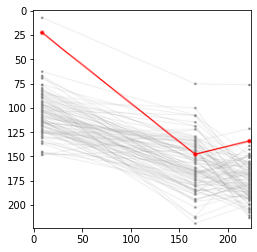

In [217]:
item = random.randint(0,len(train_label))
print(train_label[item])
showImg(train_img[item])

### Train a toy deep nerual network model
- Ref: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529

In [ ]:
model_name='CNN_model'
print("Model name: %s"%model_name)
model = cnn_model(model_name)
model.summary()

In [218]:
model_name='MobileNet_v1'
print("Model name: %s"%model_name)
model = cnn_model(model_name)
model.summary()

Model name: MobileNet_v1
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              4253864   
_________________________________________________________________
flatten_10 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 1026      
Total params: 4,767,402
Trainable params: 4,745,514
Non-trainable params: 21,888
_________________________________________________________________


In [220]:
batch_size = 30
epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(project_name+'_'+model_name+'.h5',
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_labels_one_hot,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_labels_one_hot), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
model.evaluate(test_img, test_labels_one_hot)

Epoch 1/50
1458/1458 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.8894
Epoch 00001: val_accuracy improved from -inf to 0.89053, saving model to rare_split_dup_MobileNet_v1.h5
1458/1458 [==============================] - 254s 174ms/step - loss: 0.2580 - accuracy: 0.8894 - val_loss: 0.2459 - val_accuracy: 0.8905
Epoch 2/50
1458/1458 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.8913
Epoch 00002: val_accuracy did not improve from 0.89053
1458/1458 [==============================] - 249s 171ms/step - loss: 0.2290 - accuracy: 0.8913 - val_loss: 0.2671 - val_accuracy: 0.8905
Epoch 3/50
1458/1458 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.8878
Epoch 00003: val_accuracy improved from 0.89053 to 0.89601, saving model to rare_split_dup_MobileNet_v1.h5
1458/1458 [==============================] - 251s 172ms/step - loss: 0.2226 - accuracy: 0.8878 - val_loss: 0.2136 - val_accuracy: 0.8960
Epoch 4/50
1458/1458 [=======

[0.22449903190135956, 0.9045953154563904]

In [221]:
model_name='ResNet50'
print("Model name: %s"%model_name)
model = cnn_model(model_name)
model.summary()

Model name: ResNet50
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten_11 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 1026      
Total params: 26,150,250
Trainable params: 26,097,130
Non-trainable params: 53,120
_________________________________________________________________


In [222]:
batch_size = 16
epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(project_name+'_'+model_name+'.h5',
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)
history = model.fit(train_img, train_labels_one_hot,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_labels_one_hot), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
model.evaluate(test_img, test_labels_one_hot)

Epoch 1/50
2734/2734 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.8904
Epoch 00001: val_accuracy improved from -inf to 0.89053, saving model to rare_split_dup_ResNet50.h5
2734/2734 [==============================] - 497s 182ms/step - loss: 0.3163 - accuracy: 0.8904 - val_loss: 0.3891 - val_accuracy: 0.8905
Epoch 2/50
2734/2734 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.8910
Epoch 00002: val_accuracy did not improve from 0.89053
2734/2734 [==============================] - 490s 179ms/step - loss: 0.2419 - accuracy: 0.8910 - val_loss: 0.3029 - val_accuracy: 0.8879
Epoch 3/50
2734/2734 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.8930
Epoch 00003: val_accuracy did not improve from 0.89053
2734/2734 [==============================] - 491s 180ms/step - loss: 0.2345 - accuracy: 0.8930 - val_loss: 0.4573 - val_accuracy: 0.8389
Epoch 4/50
2734/2734 [==============================] - ETA: 0s - loss: 0.2340 - accu

[0.2269258201122284, 0.9101508855819702]

Text(0.5, 1.0, 'Loss Curves')

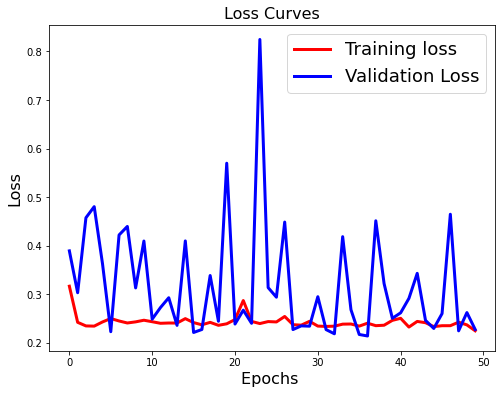

In [223]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'rare_split_dup accuracy curves')

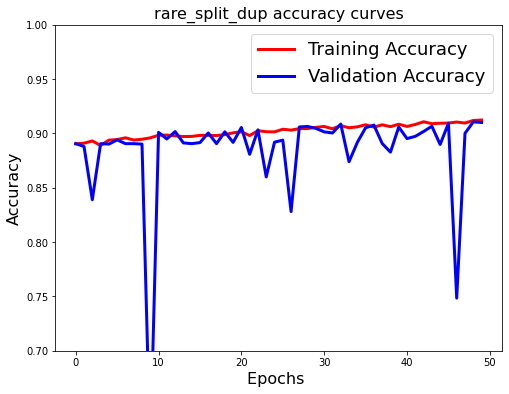

In [224]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim(0.7, 1)
plt.title(project_name+' accuracy curves',fontsize=16)

### ROC curve

In [230]:
print(project_name, model_name)

rare_split_dup ResNet50


In [231]:
## Load pre-calculated model
common_cnn_model_path = '/home/rt2776/cnv_espresso/src/' + project_name + '_model.h5'
common_cnn_model = keras.models.load_model(common_cnn_model_path)

MobileNet_model_path = '/home/rt2776/cnv_espresso/src/' + project_name + '_MobileNet_v1.h5'
MobileNet_model = keras.models.load_model(MobileNet_model_path)

ResNet50_model_path = '/home/rt2776/cnv_espresso/src/' + project_name + '_ResNet50.h5'
ResNet50_model = keras.models.load_model(ResNet50_model_path)

In [232]:
fpr_MobileNet, tpr_MobileNet, auc_MobileNet = pred_roc_data(MobileNet_model, test_img, test_labels_one_hot)
fpr_ResNet50,  tpr_ResNet50,  auc_ResNet50  = pred_roc_data(ResNet50_model,  test_img, test_labels_one_hot)
fpr_common_cnn,tpr_common_cnn,auc_common_cnn= pred_roc_data(common_cnn_model,test_img, test_labels_one_hot)

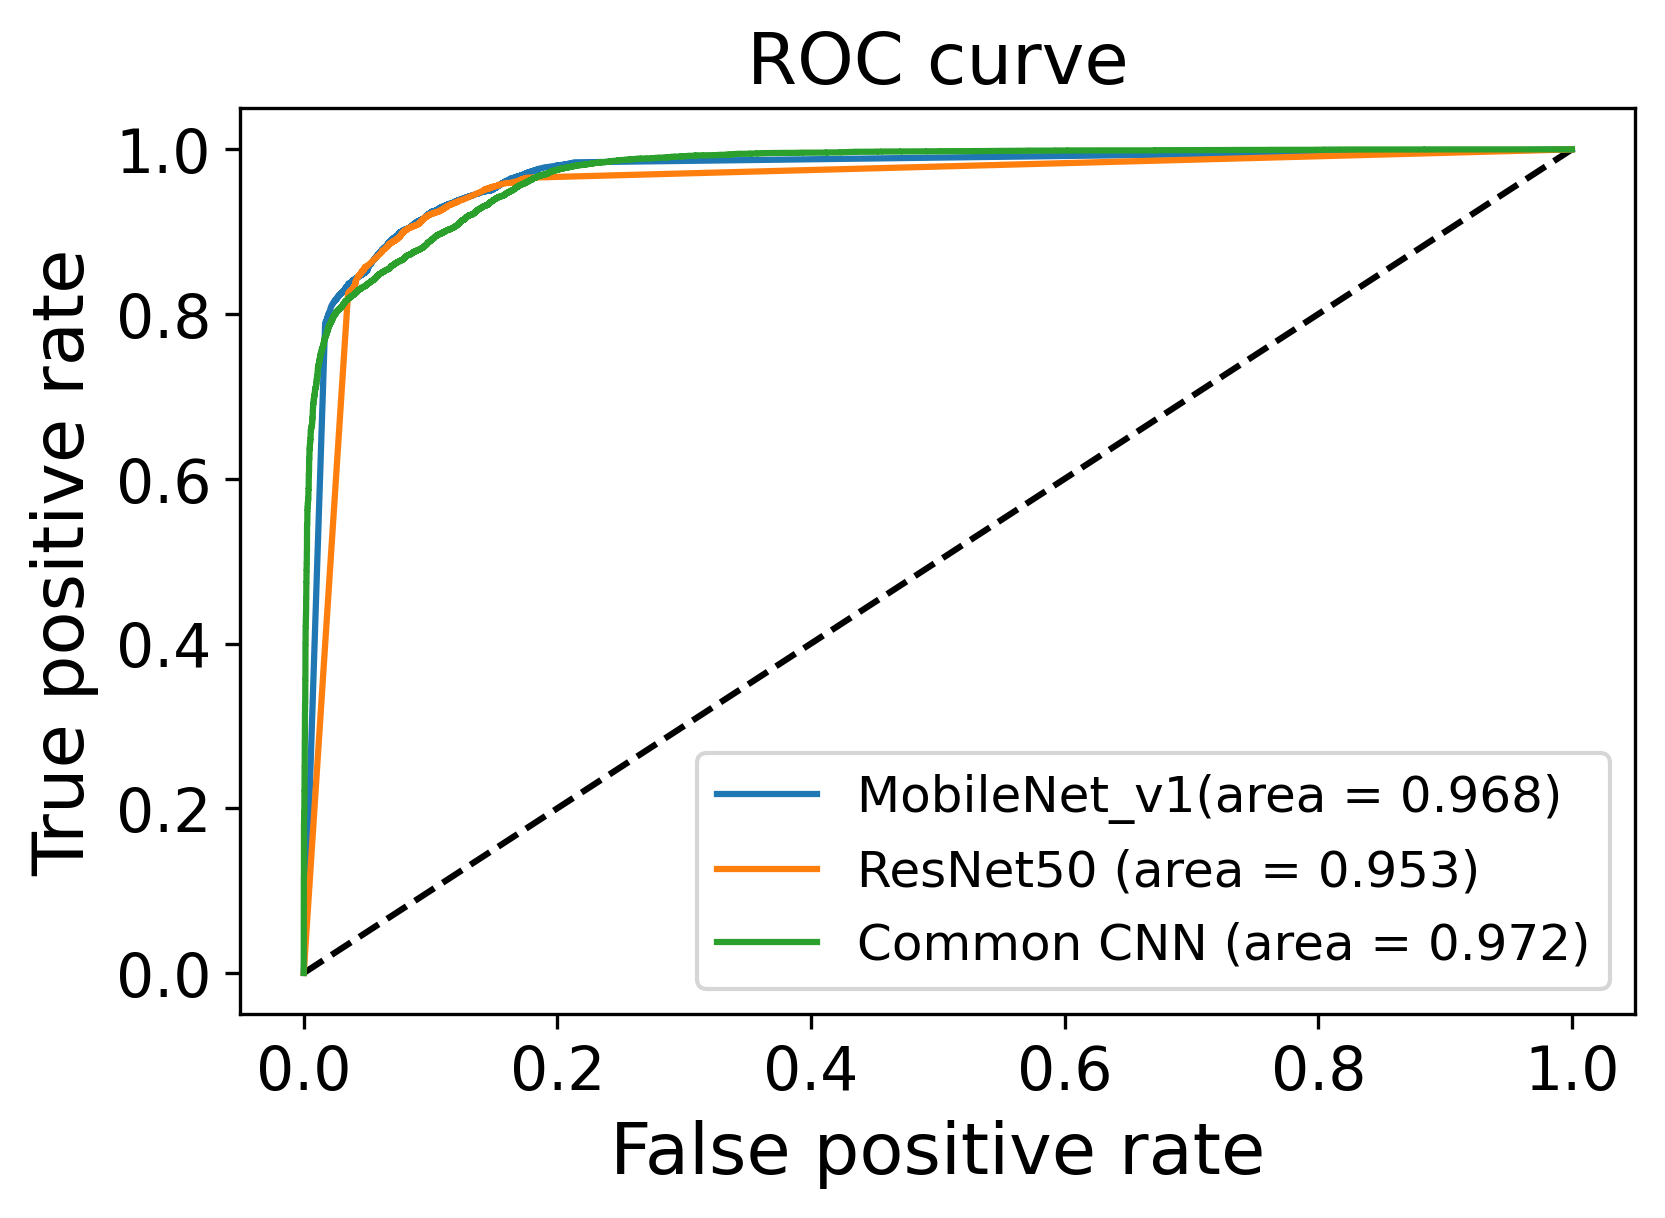

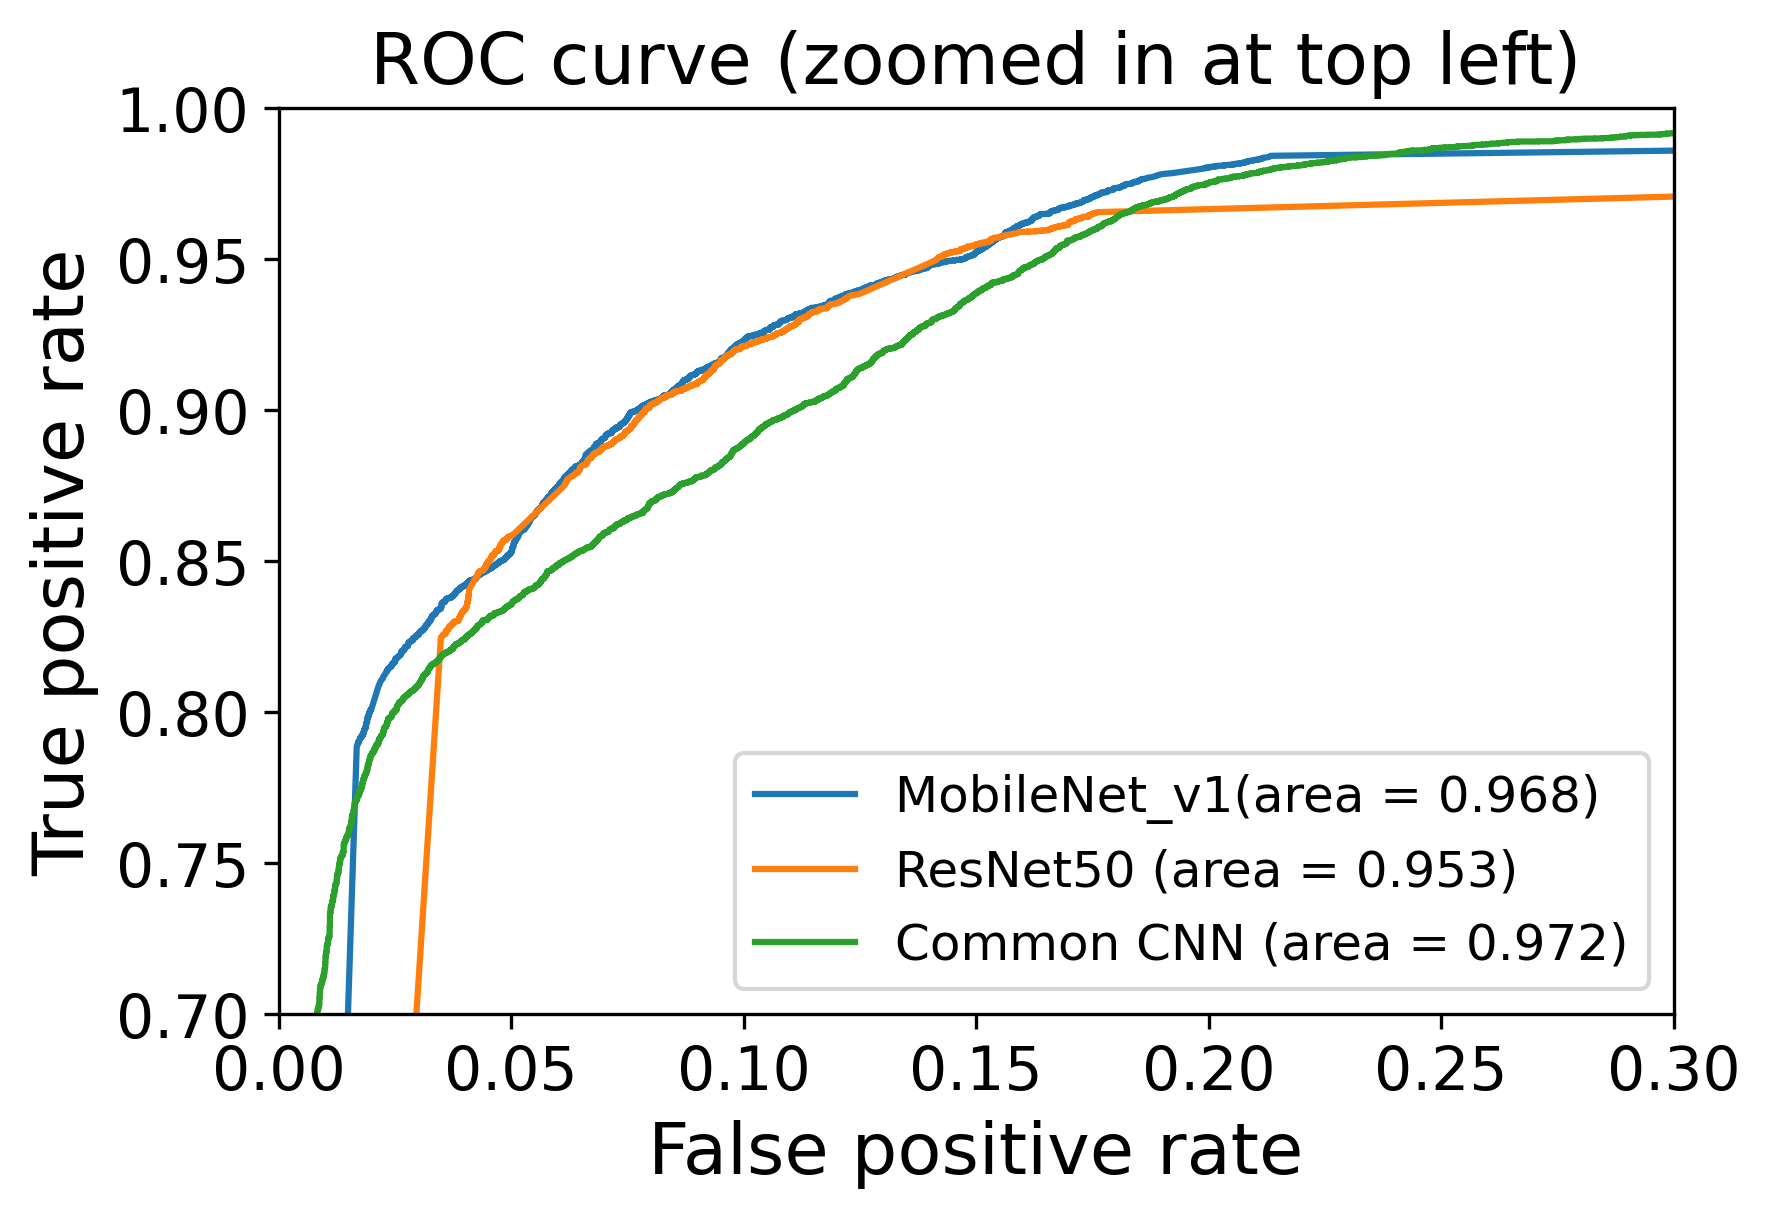

In [233]:
plt.figure(1,dpi=300)
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2,dpi=300)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

In [49]:
print(project_name)
time_stamp = datetime.datetime.now()
time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
print(time_str)

rare_entire_dup
2021.02.01-08:09:26


## Precision

In [ ]:
test_pred = model1.predict(test_img)

In [ ]:
test_output_df = copy.deepcopy(test_cnv_info_df)
test_output_df.shape

In [ ]:
test_output_df.insert(test_output_df.shape[1], 'Prob_True', "")
test_output_df.insert(test_output_df.shape[1], 'Prob_False', "")
test_output_df.insert(test_output_df.shape[1], 'Prediction', "")
test_output_df.insert(test_output_df.shape[1], 'Pred_status', "")

In [ ]:
test_output_df.shape,test_pred.shape, test_cnv_info_df.shape

In [ ]:
num, correct_count = 0, 0
for i in range(len(test_pred)):
    num += 1
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_False')] = test_pred[i][0]
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_True')] = test_pred[i][1]

    if(np.argmax(test_pred[i]) == 0):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Negative"
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Positive"
        
    if(np.argmax(test_pred[i]) == test_label[i]):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Correct"
        correct_count += 1
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Wrong"
#     print(num, test_pred[i], test_label[i], pred_status)
score = correct_count/len(test_pred)
print('Accuracy for testing data: %.2f%s' % (score*100,'%'))

In [ ]:
## output to file
output_path = '/home/rt2776/cnv_espresso/output/'
test_output_df.to_csv(output_path+project_name+'_test_predict_info.csv',index=False)


In [ ]:
test_output_df[test_output_df['Pred_status']=='Wrong']

In [ ]:
test_output_df.index=range(len(test_output_df))

In [ ]:
#i=random.randrange(len(test_img))
i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
showImg(test_img[i]), 
print(test_label[i], test_pred[i],  test_output_df.iloc[i,:])

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a